# Assignment 3

This assignment contains 4 sections:
- Data
- Eigenface Representation
- Classification
- Face Detection

In [2]:
# All imports
from os.path import abspath, join
from os import listdir
from cv2 import imread, IMREAD_GRAYSCALE, resize
import cv2
from pandas import read_csv, Series
from random import shuffle
from matplotlib.pyplot import subplots, setp, imshow
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from copy import deepcopy
from math import sqrt

# The path to the images is the relative path in this repo `./images`
image_folder = abspath('./images')
print("image folder: " + image_folder)

image folder: /home/alix/Desktop/school/semester_5/ECSE-415/assignment3/images


## Data

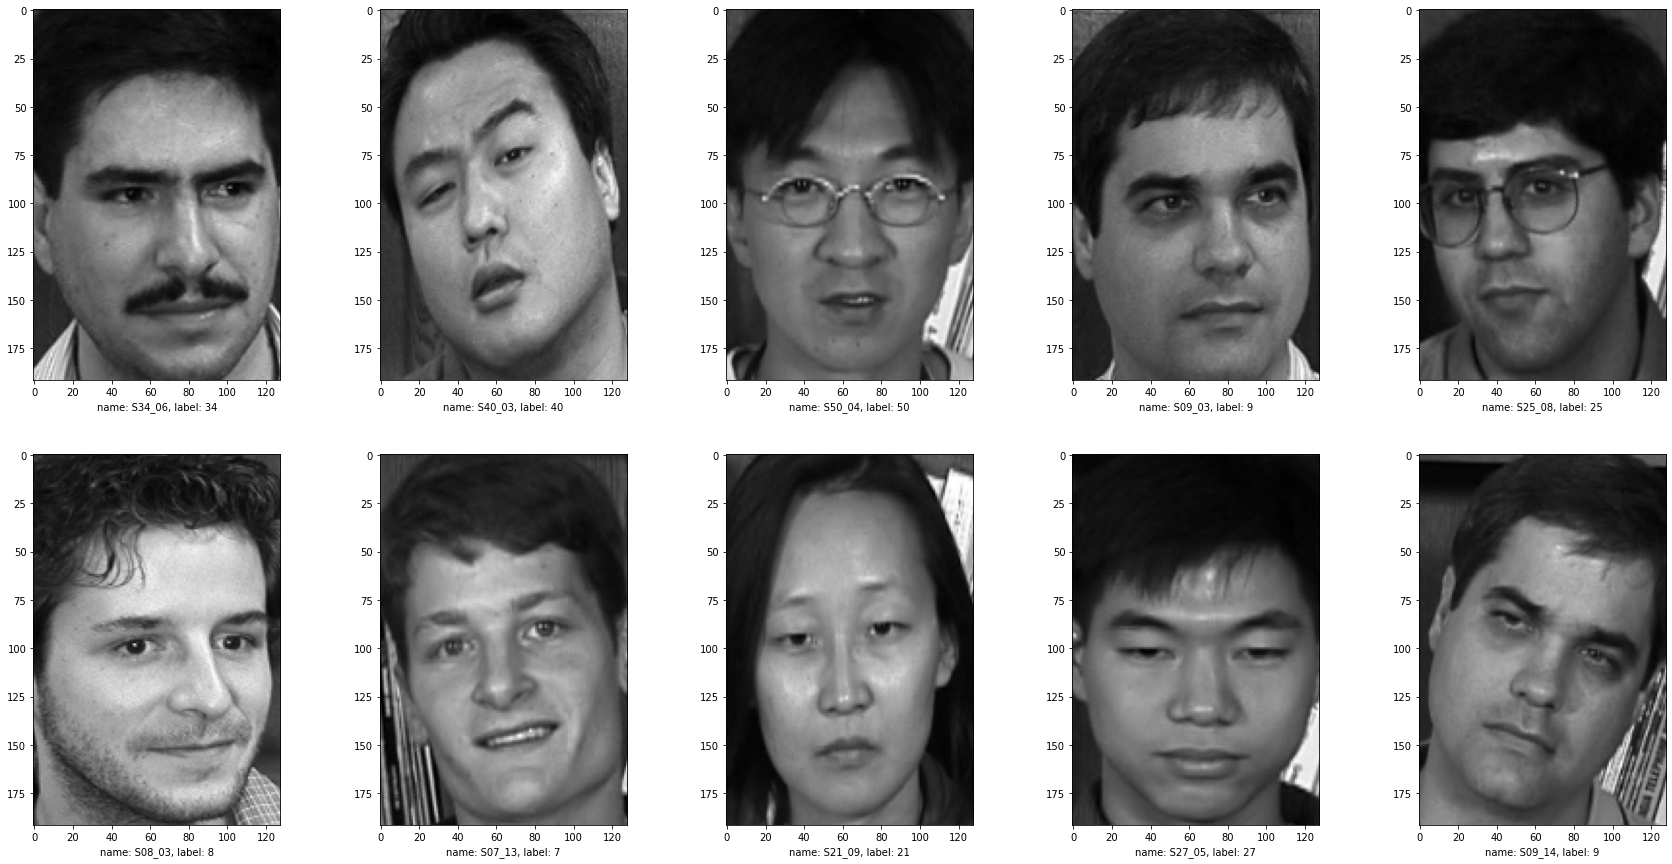

In [3]:
# preparing labels
labels = read_csv(join(image_folder, 'mapping.csv'))
labels = Series(labels.Label.values,index=labels.Image).to_dict()

# preparing face array
faces = []

# image folder for individual faces
face_images_folder = join(image_folder, 'Georgia_Tech_Face_Database')

# adding faces with their names and labels to the face array
for image in listdir(face_images_folder):
    faces.append({
        'name': 'S' + image[1:-4],
        'label': labels['S' + image[1:-4]],
        'image': resize(imread(join(face_images_folder, image), IMREAD_GRAYSCALE), (128, 192))
    })

# shuffling the set to have every face types in every set
shuffle(faces)

# splitting the set in 2
split = int(len(faces) * 0.8)
training_set, testing_set = faces[:split], faces[split:]

# displaying 10 images

f, source = subplots(2, 5, figsize=(30, 15))

for i, v in enumerate(training_set[:10]):
    source[i % 2, i % 5].imshow(v['image'], cmap='gray')
    setp(source[i % 2, i % 5], xlabel='name: ' + v['name'] + ', label: ' + str(v['label']))



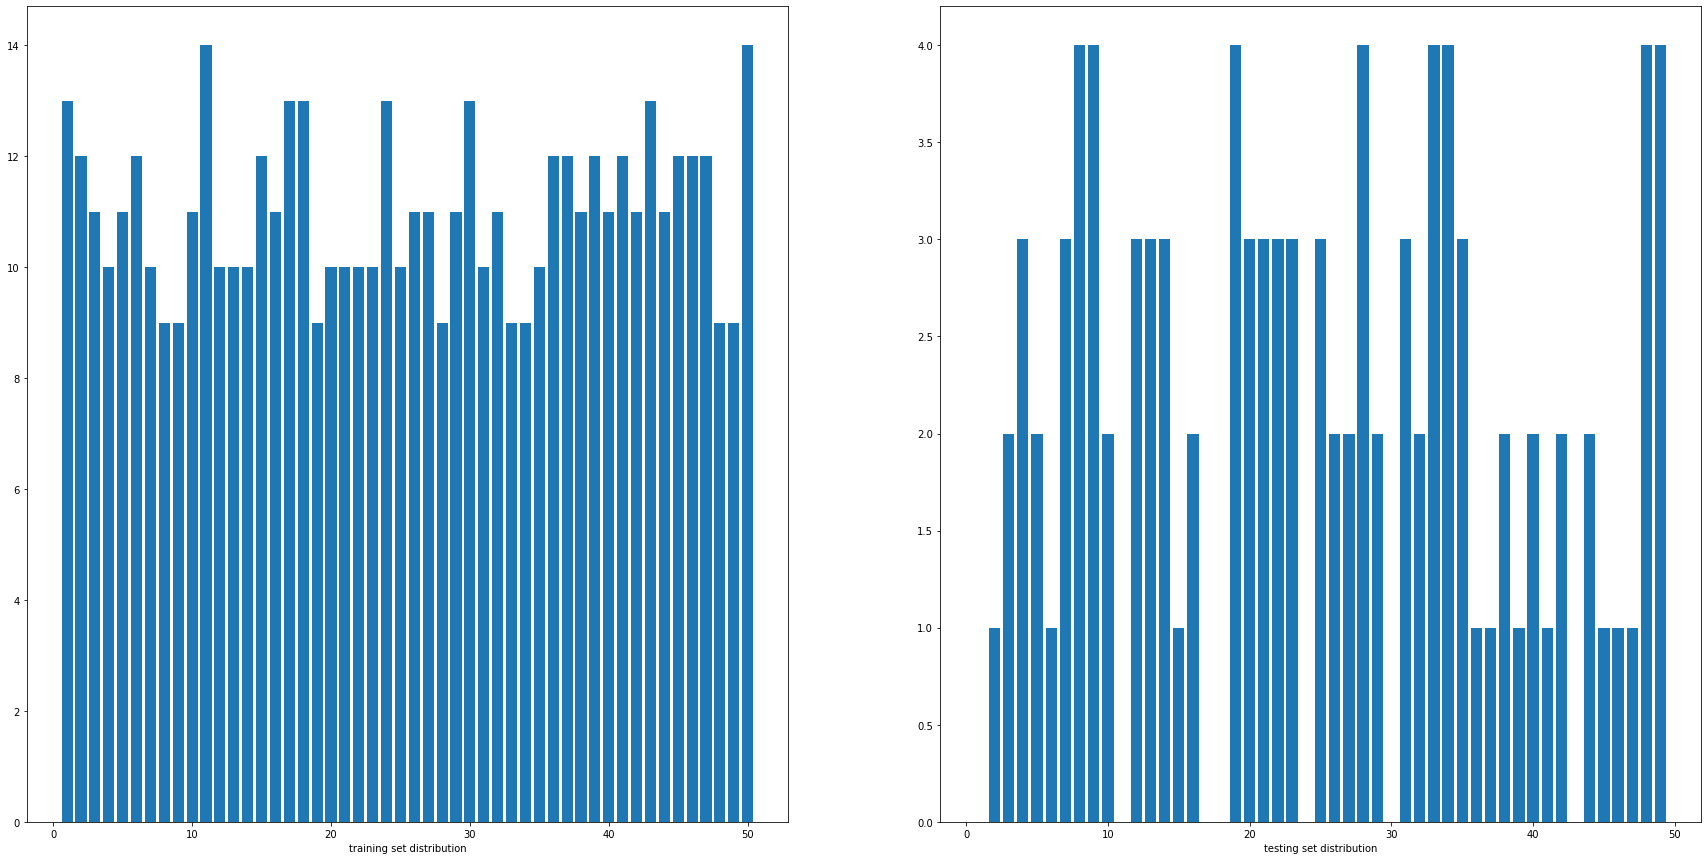

In [4]:
f, distribution = subplots(1, 2, figsize=(30, 15))

labels = ['training set', 'testing set']

set_dict = [{}, {}]


for i, cur_set in enumerate([training_set, testing_set]):
    label_dict = set_dict[i]
    for v in cur_set:
        if v['label'] in label_dict:
            label_dict[v['label']] += 1
        else:
            label_dict[v['label']] = 0
    distribution[i].bar(*zip(*sorted(label_dict.items())))
    setp(distribution[i], xlabel=labels[i] + ' distribution')

## Eigenface Representation

In [5]:
# getting an array of 1D face images
only_faces = np.array([img['image'] for img in training_set])
flattened_faces = np.resize(only_faces, (only_faces.shape[0], only_faces.shape[1] * only_faces.shape[2]))

# normalizing images with mean
mean_face = np.mean(flattened_faces, axis=0)
mean_corrected_faces = flattened_faces - np.tile(mean_face, (only_faces.shape[0], 1))

# getting the eigenvalues/eigenvectors with the with all the images' covariance
cov = (mean_corrected_faces.dot(mean_corrected_faces.T))/only_faces.shape[0]
eigenvalues, eigenvectors = np.linalg.eig(cov)

# sorting the eigenvalues and then applying order to eigenvectors
idx = eigenvalues.argsort()[::-1]
eigenvectors = eigenvectors[:, idx]

In [6]:
# multiplying the eigenvectors on our mean corrected faces
original_eigenfaces = mean_corrected_faces.T.dot(eigenvectors)

# resizing and normalizing the eigenfaces
eigenfaces = np.resize(preprocessing.normalize(original_eigenfaces.T), only_faces.shape)

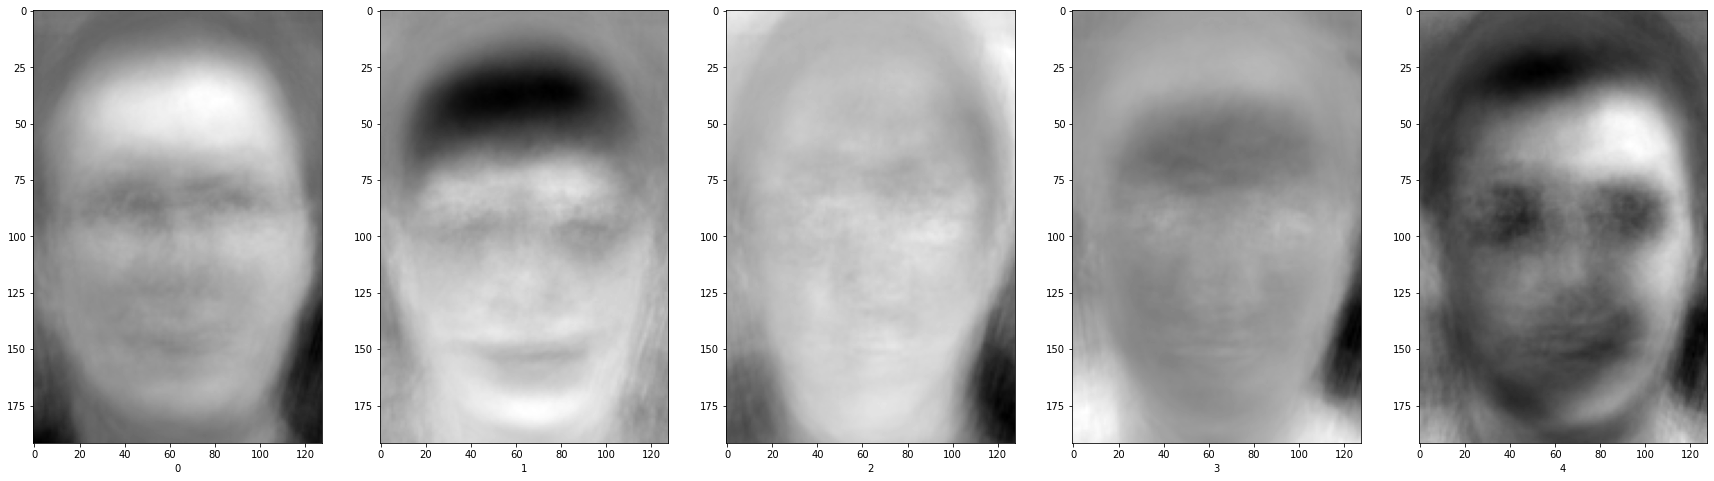

In [7]:
# plotting 5 eigenfaces

f, eigenfaces_graph = subplots(1, 5, figsize=(30, 15))

for i, v in enumerate(eigenfaces[:5]):
    eigenfaces_graph[i].imshow(v, cmap='gray')
    setp(eigenfaces_graph[i], xlabel=str(i))

We do not need all vectors to represent the data. For example, the 5 eigenfaces printed below are the less representative eigenfaces, and they barely represent a real face. They can be useful, but they are not necessary to detect a face.

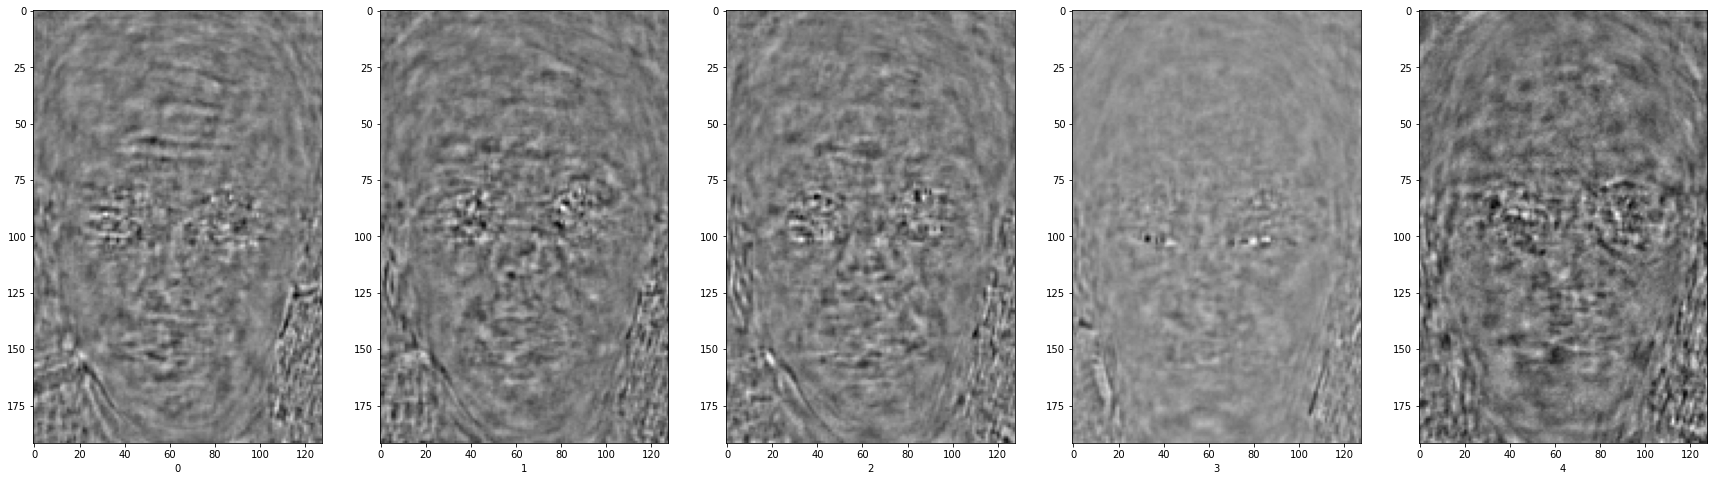

In [8]:
# plotting the 5 worst eigenfaces

f, eigenfaces_graph = subplots(1, 5, figsize=(30, 15))

for i, v in enumerate(eigenfaces[595:]):
    eigenfaces_graph[i].imshow(v, cmap='gray')
    setp(eigenfaces_graph[i], xlabel=str(i))

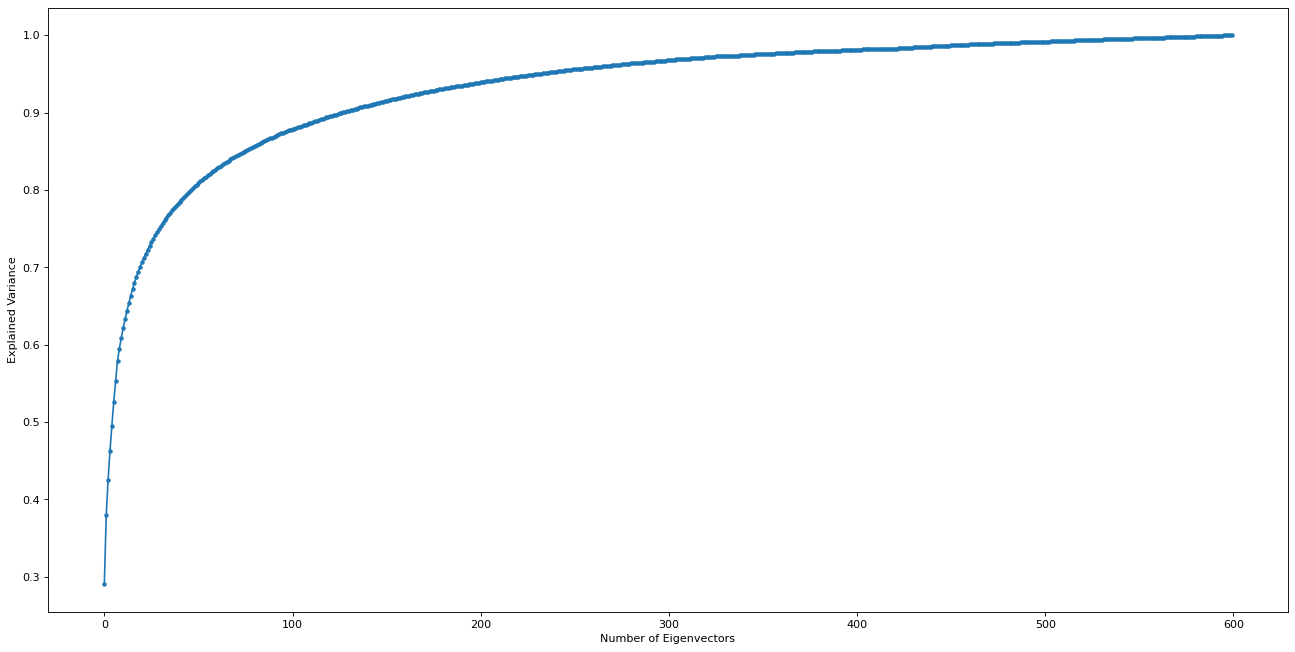

In [9]:
# Total variance vs number of eigenvectors

plt.figure(figsize=(20, 10), dpi=80)
plt.plot(np.cumsum(eigenvalues) / np.sum(eigenvalues),'.-')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Explained Variance')
plt.show()

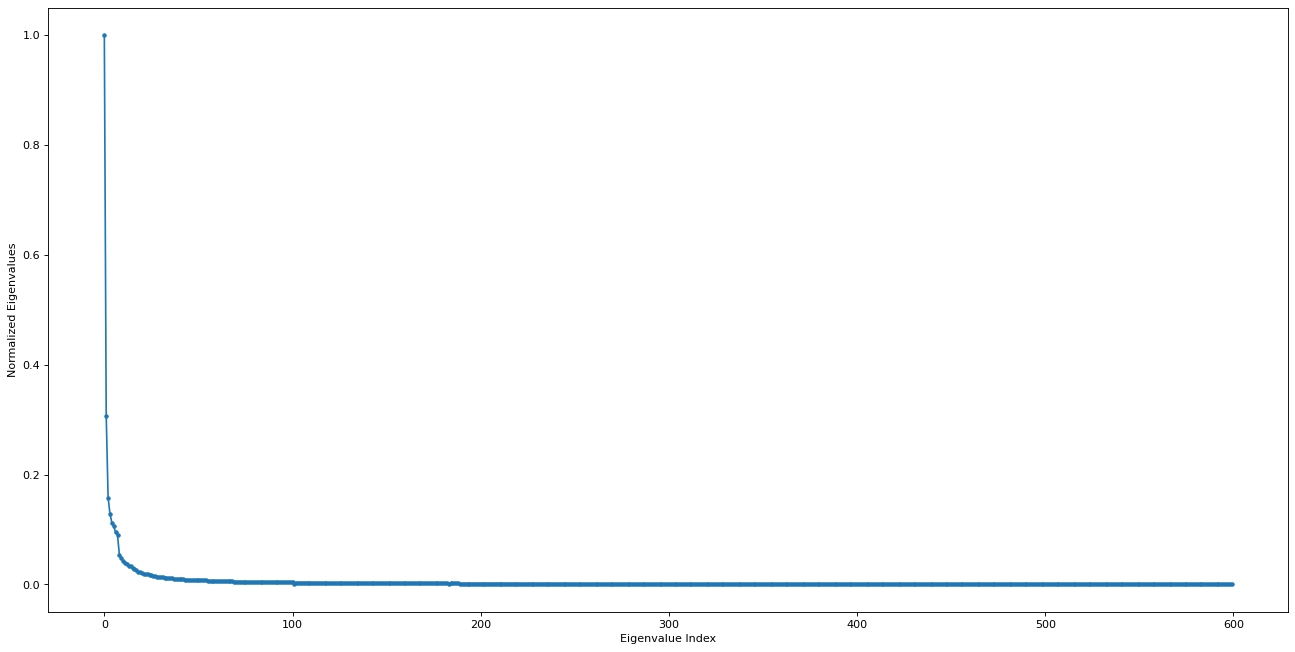

In [10]:
# Normalized Eigenvalues vd eigenvalue index

normalized_eigenvalues = eigenvalues / eigenvalues.max()

plt.figure(figsize=(20, 10), dpi=80)
plt.plot(normalized_eigenvalues,'.-')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Normalized Eigenvalues')
plt.show()

## Classification

In [11]:
# first computing the eigenvectors and extracting eigenfaces from them
only_faces_test = np.array([img['image'] for img in testing_set])
flattened_faces_test = np.resize(only_faces_test, (only_faces_test.shape[0], only_faces_test.shape[1] * only_faces_test.shape[2]))

flattened_eigenfaces = np.resize(eigenfaces, (eigenfaces.shape[0], eigenfaces.shape[1] * eigenfaces.shape[2]))

num_eigenfaces = 150

print(flattened_eigenfaces.shape)

train_eigenfaces = [flattened_eigenfaces[:num_eigenfaces].dot(img) for img in flattened_faces]
test_eigenfaces = [flattened_eigenfaces[:num_eigenfaces].dot(img) for img in flattened_faces_test]

(600, 24576)


In [12]:
# checking real picture accuracy
flattened_train_set = []
for image in training_set:
    copy = deepcopy(image)
    copy['image'] = np.resize(copy['image'], (copy['image'].shape[0] * copy['image'].shape[1]))
    flattened_train_set.append(copy)

flattened_test_set = []
for image in testing_set:
    copy = deepcopy(image)
    copy['image'] = np.resize(copy['image'], (copy['image'].shape[0] * copy['image'].shape[1]))
    flattened_test_set.append(copy)

counter = 0

for i, image1 in enumerate(flattened_test_set):
    lowest_distance = 1000000000000
    label = -1
    for image2 in flattened_train_set:
        distance = sqrt(np.sum((image1['image'] - image2['image']) ** 2))
        if distance < lowest_distance:
            label = image2['label']
            lowest_distance = distance
    if label == image1['label']:
        counter += 1

print('Real pictures accuracy: ' + str(counter * 100 / len(flattened_test_set)) + "%")

# checking eigenspace accuracy
eigen_flattened_train_set = []
for i, image in enumerate(training_set):
    copy = deepcopy(image)
    copy['image'] = train_eigenfaces[i]
    eigen_flattened_train_set.append(copy)

eigen_flattened_test_set = []
for i, image in enumerate(testing_set):
    copy = deepcopy(image)
    copy['image'] = test_eigenfaces[i]
    eigen_flattened_test_set.append(copy)

counter = 0

for i, image1 in enumerate(eigen_flattened_test_set):
    lowest_distance = 1000000000000
    label = -1
    for image2 in eigen_flattened_train_set:
        distance = sqrt(np.sum((image1['image'] - image2['image']) ** 2))
        if distance < lowest_distance:
            label = image2['label']
            lowest_distance = distance
    if label == image1['label']:
        counter += 1

print('Eigenspace pictures accuracy: ' + str(counter * 100 / len(eigen_flattened_test_set)) + "%")


Real pictures accuracy: 90.66666666666667%
Eigenspace pictures accuracy: 76.0%


You would expect to be a significative difference between the accuracy between both because there is a significative loss in data in the eigenspace. There is then less to compare with, meaning that the eigenspace accuracy would be lower.

In [13]:
training_set_labels = np.array([img['label'] for img in training_set])
testing_set_labels = np.array([img['label'] for img in testing_set])

#initializing the classifiers
linear_clf = LinearSVC(C=0.001)
rbf_clf = SVC(gamma=0.001, C=100.)
rfc_clf = RandomForestClassifier(n_estimators=100, max_depth=10, criterion='entropy')
        

In [14]:
print_classifier = ['Linear SVM', 'SVM with RBF kernel', 'Random Forest Classifier']

label_dict = {}
for i in range(1, 51):
    label_dict[i] = [0, 0]

for i, classifier in enumerate([linear_clf, rbf_clf, rfc_clf]):
    classifier.fit(train_eigenfaces, training_set_labels)
    # predicting with the testing set
    predicted_labels = classifier.predict(test_eigenfaces)

    # getting the accuracy
    temp_predict = testing_set_labels - predicted_labels
    print(print_classifier[i] + " accuracy: " + str(np.count_nonzero(temp_predict == 0) * 100 / len(temp_predict)) + '%')

    # preparing dict for next question
    if i == 0:
        for i, v in enumerate(predicted_labels):
            if v == testing_set_labels[i]:
                label_dict[v][0] += 1
            label_dict[v][1] += 1

/home/alix/Desktop/school/semester_5/ECSE-415/assignment3/assignment3/lib64/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVM accuracy: 77.33333333333333%
SVM with RBF kernel accuracy: 0.0%
Random Forest Classifier accuracy: 64.0%


They are all more accurate than the nearest neighbor classifier, where Linear SVM > Random Forest Classifier, and idk what's happening with RBF SVM

/tmp/ipykernel_7458/2282516798.py:2: RuntimeWarning: invalid value encountered in true_divide
  y = np.array([i[0] for i in list(label_dict.values())]) * 100 / np.array([i[1] for i in list(label_dict.values())])


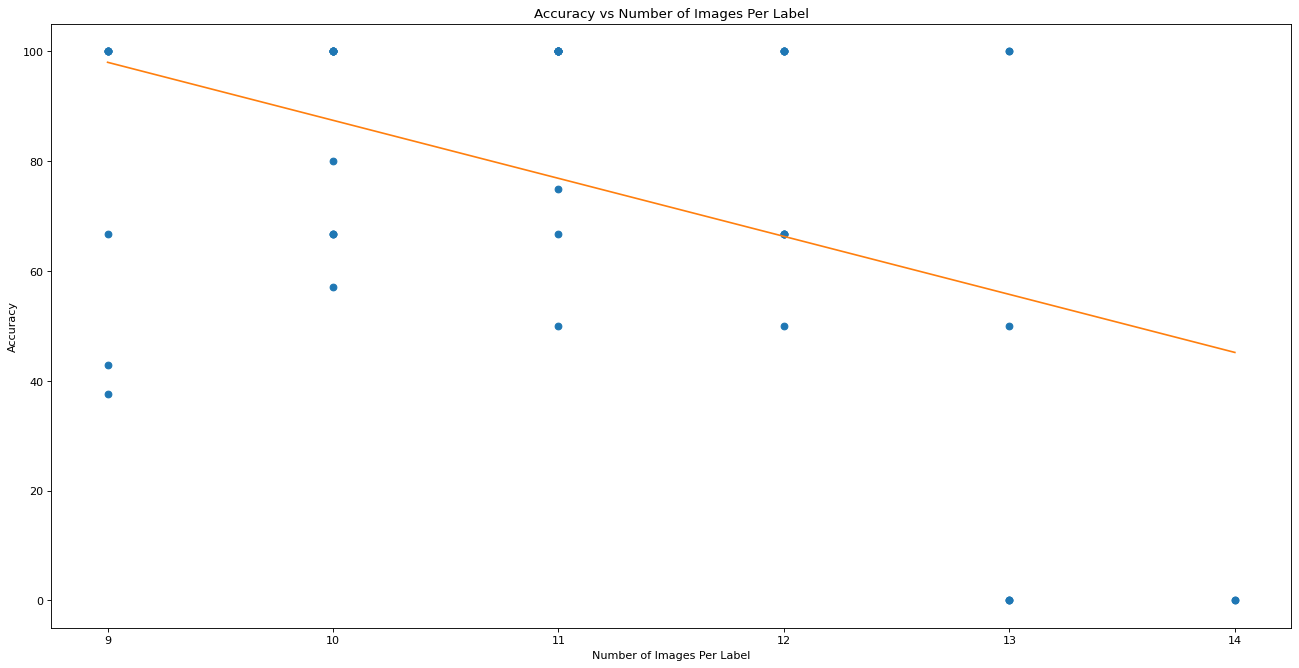

In [15]:
x = np.array([i[1] for i in sorted(set_dict[0].items())])
y = np.array([i[0] for i in list(label_dict.values())]) * 100 / np.array([i[1] for i in list(label_dict.values())])
y = np.nan_to_num(y)

plt.figure(figsize=(20, 10), dpi=80)

# plotting x and y
plt.plot(x, y, 'o')

# plotting the regression
m, b = np.polyfit(x, y, 1)
range_of_x = range(np.amin(x), np.amax(x) + 1)
plt.plot(range_of_x, m*range_of_x + b, '-')

plt.xlabel('Number of Images Per Label')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Images Per Label')
plt.show()

The accuracy generally goes down with the number of images per label. This is because our sample set is very small. If we would do the same comparison at a higher scale, the correlation would probably be the contrary.

## Face Detection

In [16]:
group_image = imread(join(image_folder, 'group_image.jpg'), IMREAD_GRAYSCALE)
scale = 4
resized_group_image = resize(group_image, (0, 0), fx=scale, fy=scale)

# resizing mean image
x_mean = 128
y_mean = 192

mean_face = np.resize(resize(np.resize(mean_face, (128, 192)), (x_mean, y_mean)), (x_mean * y_mean, ))

num_eigenfaces_detection = 7

def sliding_window(interval:int):
    """
    This function performs a sliding window while performing eigenface calculations. It stores the values at each window and returns a 2D value array.
    @param interval to which interval does the sliding window sample (to ease computational speed)
    @returns the values of the eigenface calculations
    """
    x = int((resized_group_image.shape[0] - x_mean)/interval)
    y = int((resized_group_image.shape[1] - y_mean)/interval)

    # detecting faces
    face_values = np.zeros((x, y))
    for i in range(x):
        for j in range(y):
            result = flattened_eigenfaces[:num_eigenfaces_detection].dot(np.resize(resized_group_image[i * interval: i * interval + eigenfaces.shape[1], j * interval: j * interval + eigenfaces.shape[2]], (eigenfaces.shape[1] * eigenfaces.shape[2],)))
            result = flattened_eigenfaces[:num_eigenfaces_detection].T @ result
            result = mean_face - result
            face_values[i, j] = sqrt(result.dot(result.T))
  
    return face_values

interval = 5

group_image_face_values = sliding_window(interval * scale)

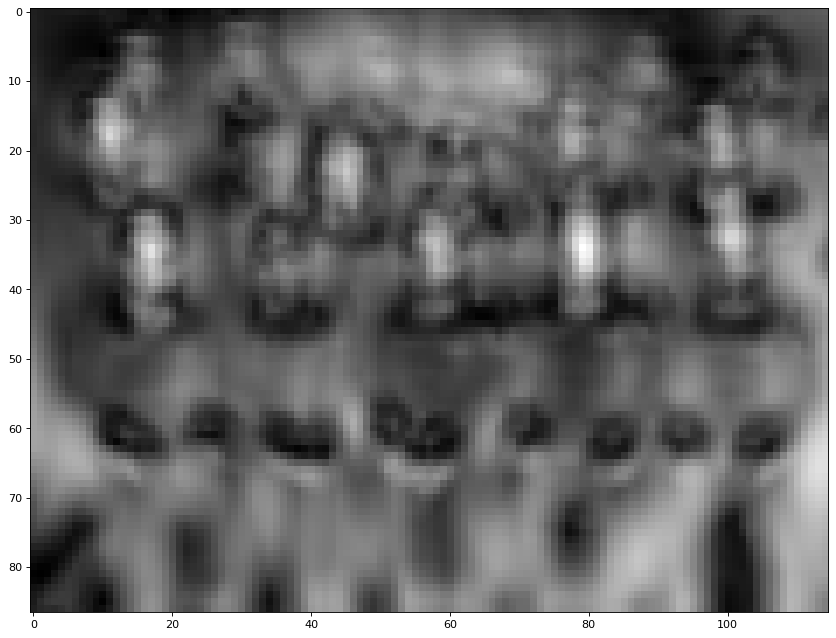

In [17]:
threshold_scale = 3

def threshold_image(img, threshold):
    """
    Thresholds the image and does non-maximum suppression operations on it.
    @param img the image to do operations on
    @param threshold the threshold value used
    @returns the thresholded image
    """
    copy = deepcopy(img)
    copy[copy < threshold] = 0

    # non-maximum suppression
    thresholded_image = np.zeros(copy.shape)   
    for i, v1 in enumerate(copy):
        for j, v2 in enumerate(v1):
            for k in range(-threshold_scale, threshold_scale + 1):
                for l in range(-threshold_scale, threshold_scale + 1):
                    if i + k >= 0 and j + l >= 0 and i + k < copy.shape[0] and j + l < copy.shape[1] and v2 < copy[i + k, j + l]:
                        continue
                    thresholded_image[i, j] = v2
    return thresholded_image

plt.figure(figsize=(20, 10), dpi=80)
imshow(threshold_image(group_image_face_values, 0), cmap='gray')

In [18]:
def display_threshold(threshold:int):
    """
    Thresholds eigenface map, oevrlaps rectangles where faces were detected, and displays the image.
    """
    copy = deepcopy(group_image)
    
    indices = np.transpose(np.nonzero(threshold_image(group_image_face_values, threshold)))
    for (y, x) in indices:
        # cv2.circle(copy, shape, 3, (255,0,0), -1)
        copy = cv2.rectangle(copy,(x * interval,y * interval),(x * interval + int(x_mean / scale), y * interval + int(y_mean / scale)),(255,0,0),1)

    plt.figure(figsize=(20, 10), dpi=80)
    imshow(copy, cmap='gray')

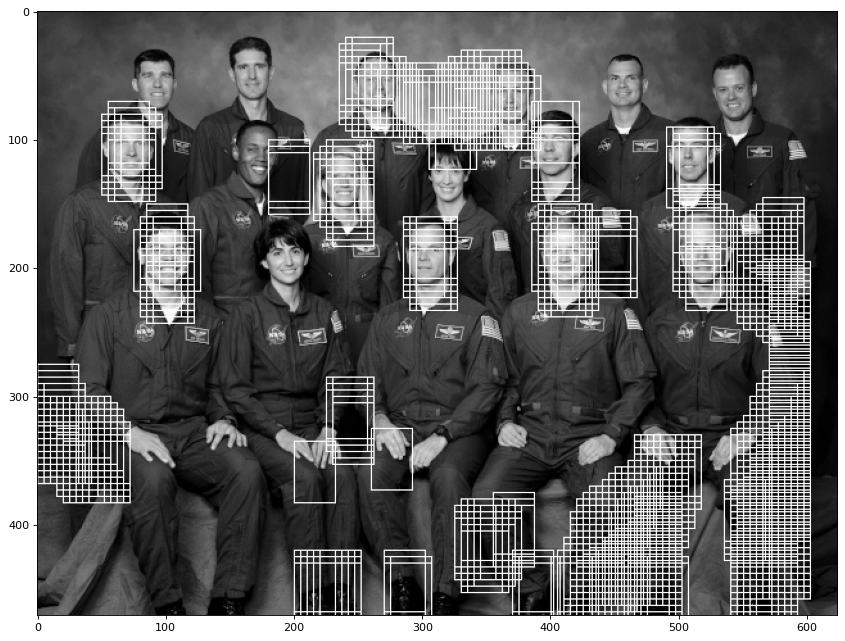

In [19]:
display_threshold(10000)

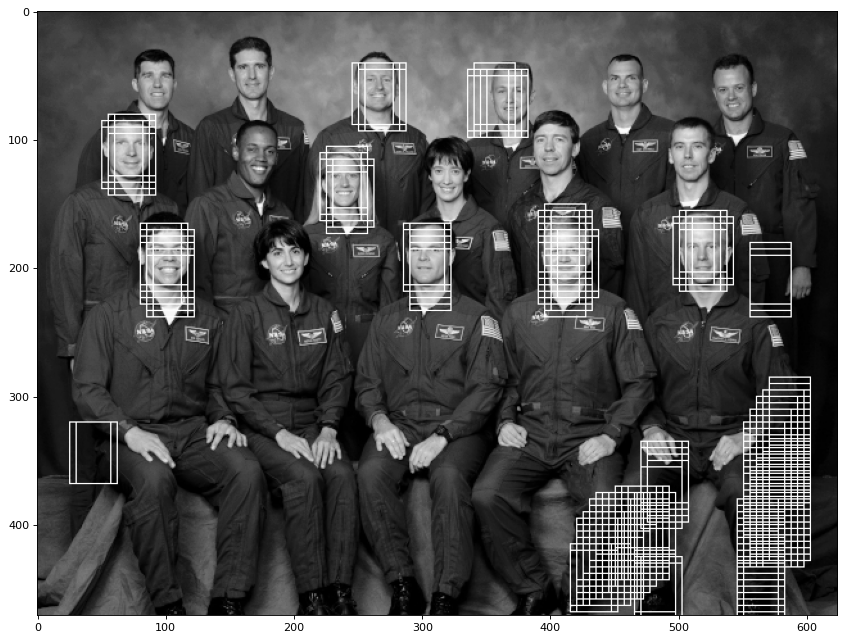

In [20]:
display_threshold(11000)

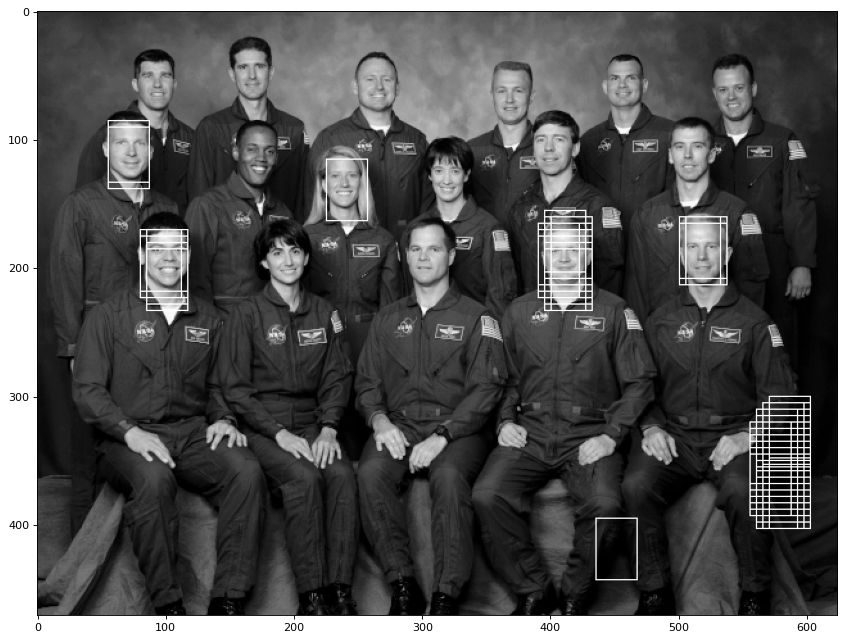

In [21]:
display_threshold(12000)

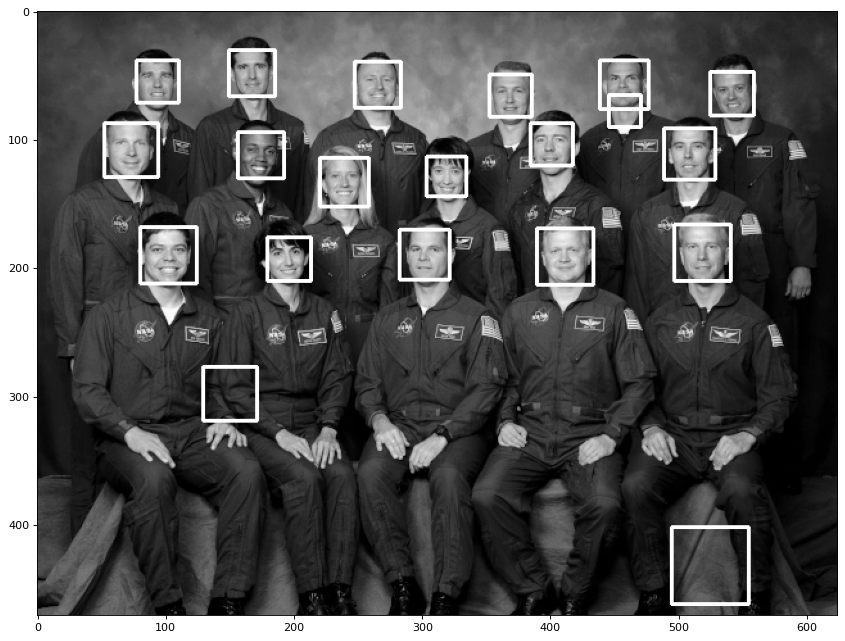

In [22]:
# initializing the classifier and using it on the image
face_cascade = cv2.CascadeClassifier(join(image_folder, 'haarcascade_frontalface_default.xml'))
faces = face_cascade.detectMultiScale(group_image, 1.1, 2)

# displaying the rectangles
for (x,y,w,h) in faces:
    group_image = cv2.rectangle(group_image,(x,y),(x+w,y+h),(255,0,0),2)

plt.figure(figsize=(20, 10), dpi=80)
plt.imshow(group_image, cmap="gray")

The Viola-Jones algorithm and the eigenface algorithm both have false positives, but what makes V-J better is that there are no false negatives (there are more true positives).

The V-J algorithm is a lot faster, because it is very good to eliminate rapidly non-face images. Under time constraint or live video, V-J would work, but not our implementation.